# **Final Project Task 3 - Census Modeling Regression**

Requirements

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the linregRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup:
    - Implement multiple models, to solve a regression problem using traditional ML:
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice.
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons.


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation
    - Establish a Baseline Model:
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection:
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation:
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
    - Hyperparameter Tuning:
        - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments.
        - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
        - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation
    - Evaluate models on the test dataset using regression metrics:
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - RÂ² Score
    - Compare the results across different models. Save all experiment results into a table.

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

In [297]:
# Load Preprocessed Dataset
data = pd.read_csv('full_preprocessed_data.csv')
full_train_data = pd.read_csv("train_preprocessed_normalized.csv")
full_test_data = pd.read_csv("test_preprocessed_normalized.csv")

X_train_normal = pd.read_csv("X_train_normal.csv")
X_test_normal  = pd.read_csv("X_test_normal.csv")

y_train = pd.read_csv("y_train.csv")
y_test  = pd.read_csv("y_test.csv")

In [298]:
# Load data
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [299]:
# Drop unnecessary features based on EDA
keep = ['income','sex','marital-status_Married-civ-spouse','age_group_Mid Career (35-54)','education-num',
        'workclass_Self-emp-inc', 'workclass_Private', 'male_with_own_child', 'age_group_Retirement Age (65+)',
        'marital-status_Never-married', 'relationship_Own-child', 'age', 'education_age_ratio', 'capital-gain']

X_train_normal = X_train_normal.filter(items=keep)
X_test_normal = X_test_normal.filter(items=keep)

X_train_normal.sample(5)
X_test_normal.sample(5)

income  sex  marital-status_Married-civ-spouse  \
5018       0    1                                  1   
1816       1    1                                  1   
1056       1    1                                  1   
5990       1    0                                  0   
3874       0    0                                  0   

      age_group_Mid Career (35-54)  education-num  workclass_Self-emp-inc  \
5018                             0      -0.423694                       0   
1816                             0       1.136639                       0   
1056                             0      -0.423694                       0   
5990                             0       1.136639                       0   
3874                             0      -0.423694                       0   

      workclass_Private  male_with_own_child  age_group_Retirement Age (65+)  \
5018                  1                    0                               0   
1816                  1                    0                               0   
1056                  1                    0                               0   
5990                  1                    0                               0   
3874                  0                    0                               0   

      marital-status_Never-married  relationship_Own-child       age  \
5018                             0                       0  1.613533   
1816                             0                       0 -0.327559   
1056                             0                       0 -0.402217   
5990                             1                       0 -0.700846   
3874                             0                       0 -0.999476   

      education_age_ratio  capital-gain  
5018             0.147541     -0.300371  
1816             0.371429      3.407728  
1056             0.264706      3.031803  
5990             0.433333     -0.300371  
3874             0.346154     -0.300371

In [300]:
print(f"Original X_train shape: {X_train_normal.shape}")
print(f"Original y_train shape: {y_train.shape}")

Original X_train shape: (25951, 14)
Original y_train shape: (25951,)


In [301]:
# Create a backup of y_train before splitting
y_train_full = y_train.copy()

In [302]:
# Split train set into train + validation
X_train, X_val, y_train, y_val = train_test_split(X_train_normal, y_train, test_size=0.2, random_state=42)

In [303]:
# Calculate mean and std dev for x and y (for train dataset)
x_mean_train = X_train.mean()
x_std_train = X_train.std()

y_mean_train = y_train.mean()
y_std_train = y_train.std()

- Linear Regression Model

In [304]:
# Train SGDRegressor (Gradient Descent-based Linear Regression)
sgd_model = SGDRegressor(loss="squared_error", max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train, y_train)

# Print model coeficients
print(sgd_model.intercept_, '\n', sgd_model.coef_)

[43.08405765] 
 [  2.44792385   5.07773222  -0.9344659    1.07754172   1.76698178
   5.35887044  -0.80636734  -0.82528612 -10.09220432  -1.44211176
  -5.00597511  -1.49440128 -15.85779994   0.33518521]


In [305]:
# Calculate the model predictions on train dataset
y_pred_sgd = sgd_model.predict(X_test_normal)
y_pred_unnorm = (y_pred_sgd * y_std_train) + y_mean_train

- Decision Tree Regression

In [306]:
# Train Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test_normal)

In [307]:
# Function to Evaluate Models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nðŸ“Š Results for {model_name}:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"RÂ² Score: {r2_score(y_true, y_pred):.4f}")

evaluate_model(y_test, y_pred_sgd, "SGDRegressor")
evaluate_model(y_test, y_pred_dt, "DecisionTreeRegressor")


ðŸ“Š Results for SGDRegressor:
MAE: 7.6641
MSE: 118.0324
RMSE: 10.8643
RÂ² Score: 0.1899

ðŸ“Š Results for DecisionTreeRegressor:
MAE: 8.8672
MSE: 161.2348
RMSE: 12.6978
RÂ² Score: -0.1066


**Interpretation of Model Results**
   * *SGDRegressor (Gradient Descent-Based Linear Regression)*
     *  MAE (Mean Absolute Error): 7.66 â†’ On average, predictions are 7.67 units off from the actual values.
     *  MSE (Mean Squared Error): 118.03 â†’ Squared error penalizes large errors more, indicating some large deviations.
     *  RMSE (Root Mean Squared Error): 10.86 â†’ Similar to MSE but on the same scale as the target variable. This is the expected average prediction error.
     *  RÂ² Score: 0.1899 â†’ Quite low (close to 0), meaning the model barely explains the variance in the target variable. It performs only slightly better than random guessing.
   * Conclusion: The SGDRegressor model performs poorly. A low RÂ² score suggests it struggles to capture relationships in the data. It might need better features, non-linearity adjustments, or a different model.

   * *DecisionTreeRegressor*
     *  MAE: 8.86 â†’ Higher than SGDRegressor, meaning predictions deviate more.
     *  MSE: 161.23 â†’ Much higher than the SGDRegressor, suggesting more extreme errors.
     *  RMSE: 12.69 â†’ Indicates an even larger prediction error on average.
     *  RÂ² Score: -0.1066 â†’ A negative RÂ² score means the model performs worse than a simple mean-based predictor (e.g., just predicting the average value for all inputs).
   * Conclusion: The Decision Tree severely overfits to training data and generalizes poorly. This happens when the tree grows too deep, memorizing training data instead of learning patterns.

In [308]:
# Hyperparameter tuning for Decision Tree
param_grid = {
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_dt_model = grid_search.best_estimator_
y_pred_best_tree = best_dt_model.predict(X_test_normal)
evaluate_model(y_test, y_pred_best_tree, "DecisionTreeRegressor after Hyperparameter Tuning")


ðŸ“Š Results for DecisionTreeRegressor after Hyperparameter Tuning:
MAE: 7.4226
MSE: 114.0097
RMSE: 10.6775
RÂ² Score: 0.2175


- The MAE, MSE, and RMSE have all improved, meaning the model is making better predictions.
- The RÂ² score has increased from negative to 0.2175, meaning the model is finally capturing some patterns in the data.
- However, an RÂ² of 0.2175 is still low, meaning there's a lot of unexplained variance.

In [309]:
# Save results in a table
results = pd.DataFrame({
    "Model": ["SGDRegressor", "DecisionTreeRegressor", "Best DecisionTree"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_sgd),
        mean_absolute_error(y_test, y_pred_dt),
        mean_absolute_error(y_test, y_pred_best_tree)
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred_sgd),
        mean_squared_error(y_test, y_pred_dt),
        mean_squared_error(y_test, y_pred_best_tree)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_sgd)),
        np.sqrt(mean_squared_error(y_test, y_pred_dt)),
        np.sqrt(mean_squared_error(y_test, y_pred_best_tree))
    ],
    "RÂ² Score": [
        r2_score(y_test, y_pred_sgd),
        r2_score(y_test, y_pred_dt),
        r2_score(y_test, y_pred_best_tree)
    ]
})
print('Model Evaluation Results:')
print(results.to_string(index=False))

Model Evaluation Results:
                Model      MAE        MSE      RMSE  RÂ² Score
         SGDRegressor 7.664096 118.032416 10.864272  0.189911
DecisionTreeRegressor 8.867152 161.234806 12.697827 -0.106599
    Best DecisionTree 7.422649 114.009724 10.677534  0.217520


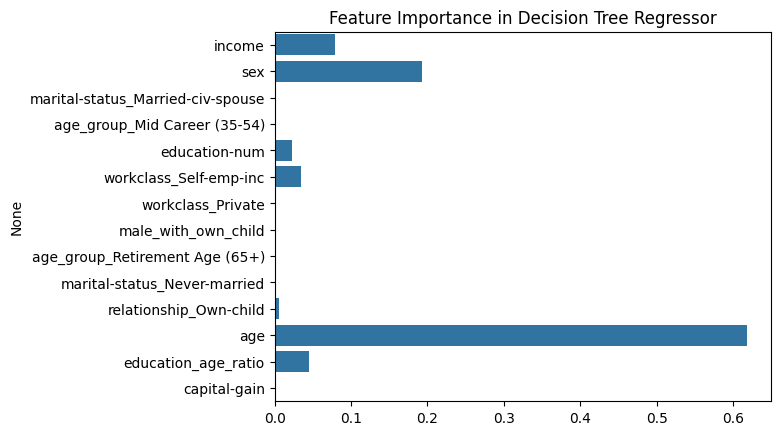

In [310]:
# Feature Importance (Only for Decision Tree)
feature_importances = best_dt_model.feature_importances_
features = X_train.columns

sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importance in Decision Tree Regressor")
plt.show()

- Feature Importance Analysis
- Top Features Driving Predictions
  *  age (~60%) â†’ The most dominant predictor.
  *  sex (~20%) â†’ Significant impact.
  *  income (~10%) â†’ Important but less than expected.
  *  Other features have minimal impact.

- Observations & Recommendations
  *  age dominates predictions, meaning work hours are largely age-dependent in the dataset.
  *  Many categorical features have near-zero importance, which suggests they arenâ€™t helping the model.

In [311]:
print(f"X_train_normal shape: {X_train_normal.shape}")
print(f"y_train shape: {y_train_full.shape}")

X_train_normal shape: (25951, 14)
y_train shape: (25951,)


In [312]:
X_train_normal = X_train_normal.reset_index(drop=True)
y_train_full = pd.Series(y_train_full).reset_index(drop=True)

- The linear regression model it's weak. I will add Polynomial Features to capture non-linearity (interaction terms like education-num * age)

In [313]:
# Add Polynomial Features to improve linear regression
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_normal)
X_test_poly = poly.transform(X_test_normal)

In [314]:
# Split train set into train + validation
X_train, X_val, y_train, y_val = train_test_split(X_train_poly, y_train_full, test_size=0.2, random_state=42)

In [315]:
# Train SGDRegressor with Polynomial Features
sgd_model = SGDRegressor(loss="squared_error", max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train, y_train)
y_pred_sgdpoly = sgd_model.predict(X_test_poly)

In [316]:
# Function to Evaluate Models
def evaluate_model(y_true, y_pred_sgdpoly, model_name):
    print(f"\nðŸ“Š Results for {model_name}:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred_sgdpoly):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred_sgdpoly):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred_sgdpoly)):.4f}")
    print(f"RÂ² Score: {r2_score(y_true, y_pred_sgdpoly):.4f}")

evaluate_model(y_test, y_pred_sgdpoly, "SGDRegressor with Polynomial Features")


ðŸ“Š Results for SGDRegressor with Polynomial Features:
MAE: 7.5188
MSE: 113.8626
RMSE: 10.6706
RÂ² Score: 0.2185


- Model performance has improved, but only marginally.
- RÂ² increased from 18.99% â†’ 21.85%, meaning the model is capturing slightly more variance.
- MSE and RMSE have dropped, meaning overall error is lower.

- However, the improvement is not dramatic. This suggests that: polynomial interactions help but donâ€™t fully capture the complexity. More advanced techniques (like feature selection or different models) may be needed.

In [317]:
# Hyperparameter tuning for SGDRegressor
param_grid = {
    'alpha': [0.001, 0.01],  # Reduced values
    'learning_rate': ['optimal', 'adaptive'],  # Fewer options
    'eta0': [0.001, 0.01],  # Reduced values
    'max_iter': [2000, 5000],  # Increase iterations to ensure convergence
    'tol': [1e-4, 1e-5]  # Lower tolerance for better results
}

In [318]:
grid_search = GridSearchCV(SGDRegressor(loss="squared_error", random_state=42), 
                           param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_sgd_model = grid_search.best_estimator_


In [319]:
# Train the best SGD model on the full training set
best_sgd_model.fit(X_train, y_train)
y_pred_sgdhyper = best_sgd_model.predict(X_test_poly)

In [320]:
# Function to Evaluate Models
def evaluate_model(y_true, y_pred_sgdhyper, model_name):
    print(f"\nðŸ“Š Results for {model_name}:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred_sgdhyper):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred_sgdhyper):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred_sgdhyper)):.4f}")
    print(f"RÂ² Score: {r2_score(y_true, y_pred_sgdhyper):.4f}")

evaluate_model(y_test, y_pred_sgdhyper, "Tuned SGDRegressor with Polynomial Features")


ðŸ“Š Results for Tuned SGDRegressor with Polynomial Features:
MAE: 7.5046
MSE: 113.4624
RMSE: 10.6519
RÂ² Score: 0.2213


In [321]:
# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'adaptive', 'max_iter': 2000, 'tol': 0.0001}


In [322]:
# Print model coefficients
print("\nSGD Regressor Model Coefficients:")
print("Intercept:", best_sgd_model.intercept_)
print("Coefficients:", best_sgd_model.coef_)


SGD Regressor Model Coefficients:
Intercept: [41.47519134]
Coefficients: [ 2.85102634e+00  3.72108857e+00 -2.10331969e+00 -6.14005215e-01
  9.75312852e-01  3.84952179e+00  2.17633086e-01  6.79890323e-01
  2.15160324e+00  1.67501234e+00  5.42285597e-01 -4.56545843e+00
 -3.87985265e+00 -1.97027466e-01  7.81493152e-01 -2.40876291e+00
 -9.48574049e-01 -2.54300626e-01 -2.96691615e-01  2.02973985e+00
 -9.81259074e-01  2.40665355e+00 -3.24858807e-01 -6.57678243e-01
  2.96049234e-01  1.60828451e+00 -1.54165275e-01  3.87877514e+00
  5.93710482e-01 -4.82498083e-01  2.28383508e+00  1.51275603e-01
  6.79890323e-01  1.31251127e+00 -8.51391669e-01  6.79890323e-01
 -3.94242274e-01 -1.60887246e+00  1.64351277e-02  2.21132539e-01
 -3.08465449e-01 -1.52419769e+00 -1.38038523e+00  6.20473211e-01
 -5.08450308e-01  0.00000000e+00  1.15102239e+00 -3.51545432e-01
 -2.40244624e-01  1.28635494e-01  3.05083248e-01  1.13933902e+00
  8.45048527e-03 -5.99760642e-01  0.00000000e+00 -1.20212864e+00
 -1.02772225e+00

- Analysis of Tuned SGDRegressor Performance
  *  MAE: 7.5046 â†’ Slight improvement.
  *  MSE: 113.4624 â†’ Lower, but not a significant change.
  *  RMSE: 10.6519 â†’ A small reduction.
  *  RÂ² Score: 0.2213 â†’ Still low, meaning the model is capturing only ~22% of the variance.
- Key Takeaways
  *  Slight improvement, but still weak.
  *  Polynomial features helped, but not enough.
  *  SGDRegressor may not be the best fit for this problem.

In [323]:
print(f"X_train shape: {X_train_normal.shape}")
print(f"X_test_normal shape: {X_test_normal.shape}")
print(f"y_train_full shape: {y_train_full.shape}")

X_train shape: (25951, 14)
X_test_normal shape: (6488, 14)
y_train_full shape: (25951,)


In [324]:
# Train Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_normal, y_train_full)
y_pred_rf = rf_model.predict(X_test_normal)
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")


ðŸ“Š Results for Random Forest Regressor:
MAE: 7.4280
MSE: 113.0466
RMSE: 10.6323
RÂ² Score: 0.2241


In [325]:
# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_normal, y_train_full)  
y_pred_gb = gb_model.predict(X_test_normal)  
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regressor")


ðŸ“Š Results for Gradient Boosting Regressor:
MAE: 7.5515
MSE: 116.3731
RMSE: 10.7876
RÂ² Score: 0.2013


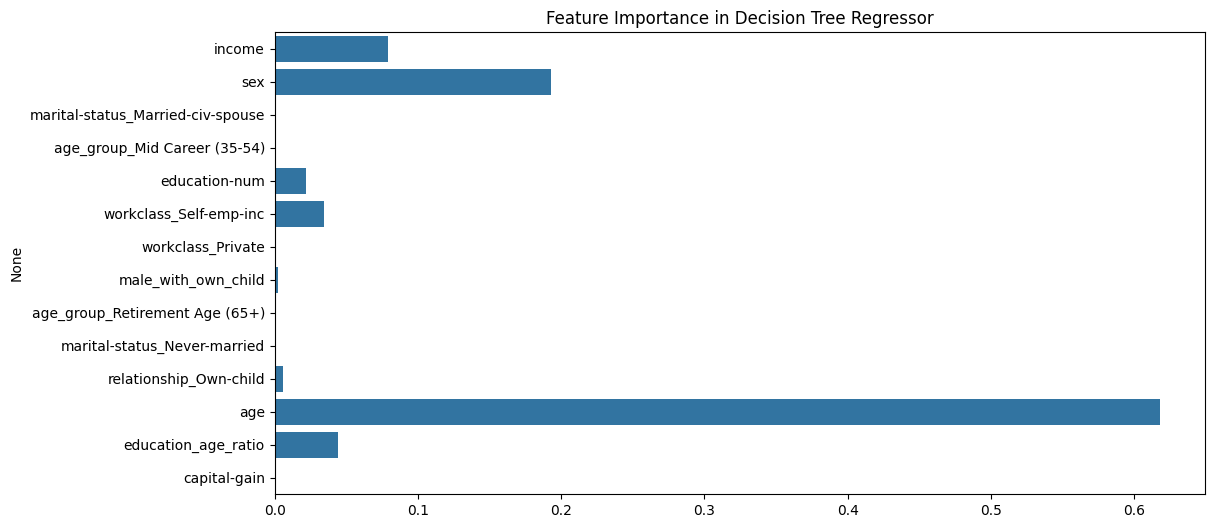

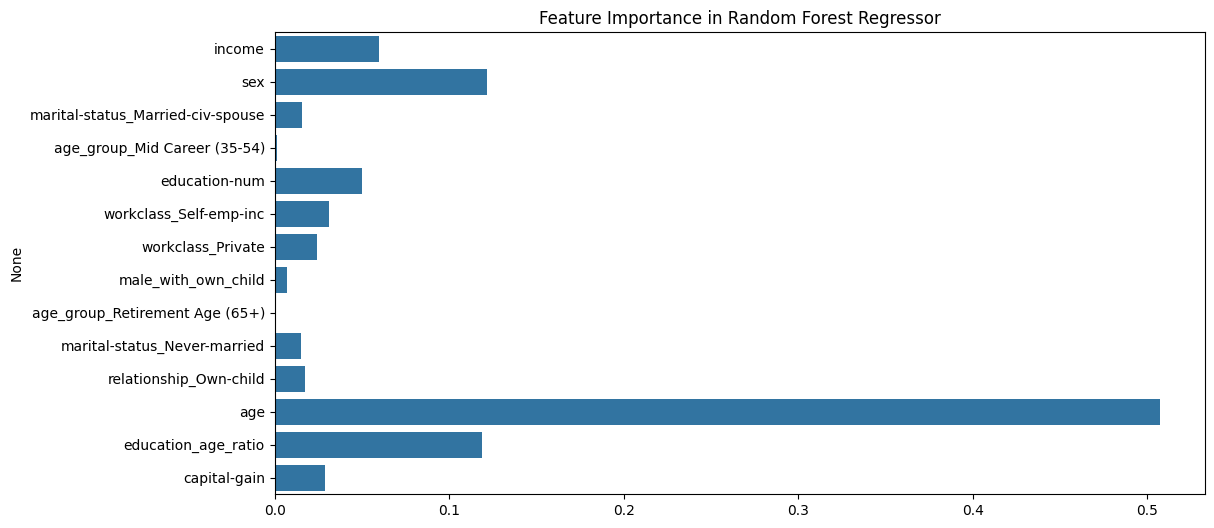

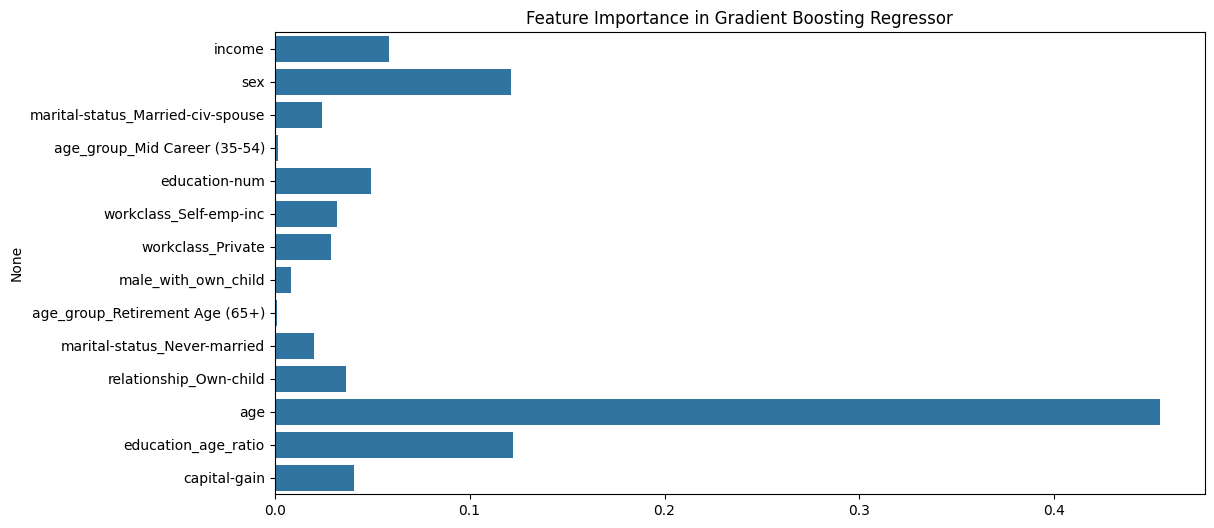

In [326]:
# Compare feature importance
X_train_df = pd.DataFrame(X_train_normal, columns=X_train_normal.columns)
plt.figure(figsize=(12, 6))
sns.barplot(x=best_dt_model.feature_importances_, y=X_train_normal.columns)
plt.title("Feature Importance in Decision Tree Regressor")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=rf_model.feature_importances_, y=X_train_normal.columns)
plt.title("Feature Importance in Random Forest Regressor")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=gb_model.feature_importances_, y=X_train_normal.columns)
plt.title("Feature Importance in Gradient Boosting Regressor")
plt.show()

In [327]:
# Drop unnecessary and low-impact features based on feature importance analysis
low_impact_features = [
    "relationship_Own-child", "marital-status_Never-married", "male_with_own_child", 
    "age_group_Retirement Age (65+)", "age_group_Mid Career (35-54)", "workclass_Private", 
    "workclass_Self-emp-inc", "education-num", "marital-status_Married-civ-spouse"
]

In [328]:
X_train_normal.drop(columns=low_impact_features, inplace=True, errors='ignore')
X_test_normal.drop(columns=low_impact_features, inplace=True, errors='ignore')

In [329]:
# Ensure consistent feature alignment between train and test sets
common_features = X_train_normal.columns.intersection(X_test_normal.columns)
X_train_normal = X_train_normal[common_features]
X_test_normal = X_test_normal[common_features]

In [330]:
# Split train set into train + validation
X_train, X_val, y_train, y_val = train_test_split(X_train_normal, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nðŸ“Š Results for {model_name}:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"RÂ² Score: {r2_score(y_true, y_pred):.4f}")


In [332]:
# Train Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_normal, y_train_full)
y_pred_dtnf = dt_model.predict(X_test_normal)
evaluate_model(y_test, y_pred_dtnf, "Decision Tree Regressor w/o some features")


ðŸ“Š Results for Decision Tree Regressor w/o some features:
MAE: 8.1278
MSE: 134.6826
RMSE: 11.6053
RÂ² Score: 0.0756


In [333]:
# Hyperparameter tuning for Decision Tree
param_grid_dt = {
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

grid_search_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_dt.fit(X_train_normal, y_train_full)
best_dt_model = grid_search_dt.best_estimator_
y_pred_best_dtnf = best_dt_model.predict(X_test_normal)
evaluate_model(y_test, y_pred_best_dtnf, "Tuned Decision Tree Regressor w/o some features")
print("Best Hyperparameters for Decision Tree:", grid_search_dt.best_params_)


ðŸ“Š Results for Tuned Decision Tree Regressor w/o some features:
MAE: 7.5192
MSE: 115.4282
RMSE: 10.7438
RÂ² Score: 0.2078
Best Hyperparameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [334]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_normal, y_train_full)
y_pred_rfnf = rf_model.predict(X_test_normal)
evaluate_model(y_test, y_pred_rfnf, "Random Forest Regressor w/o some features")


ðŸ“Š Results for Random Forest Regressor w/o some features:
MAE: 7.5269
MSE: 115.8568
RMSE: 10.7637
RÂ² Score: 0.2048


In [335]:
# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_normal, y_train_full)
y_pred_gbnf = gb_model.predict(X_test_normal)
evaluate_model(y_test, y_pred_gbnf, "Gradient Boosting Regressor w/o some features")


ðŸ“Š Results for Gradient Boosting Regressor w/o some features:
MAE: 7.6250
MSE: 118.7578
RMSE: 10.8976
RÂ² Score: 0.1849


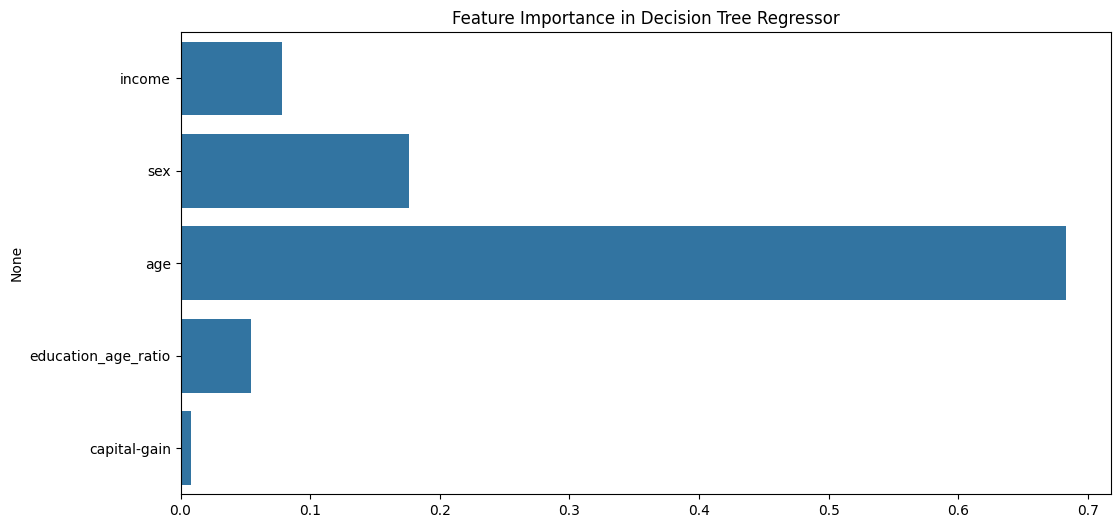

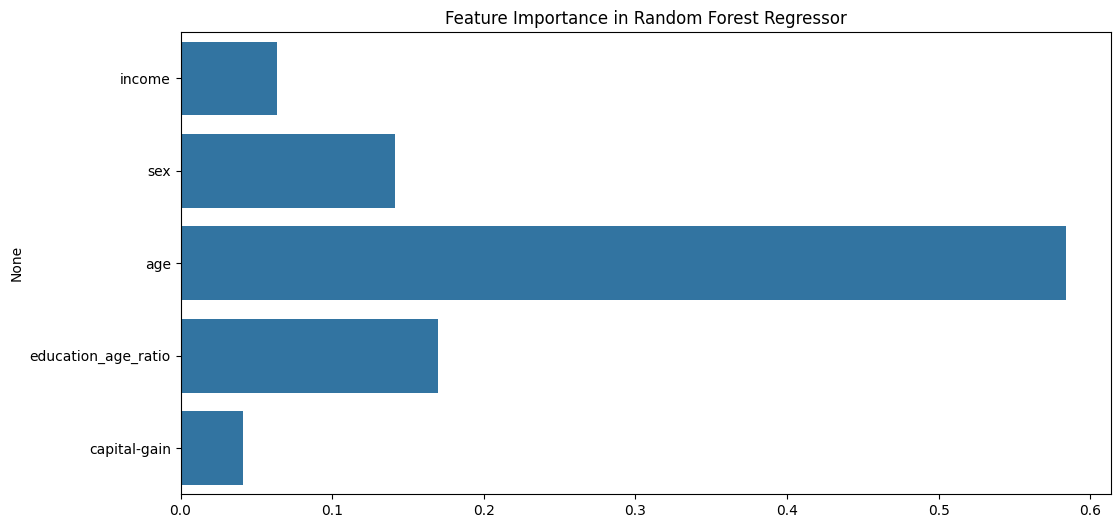

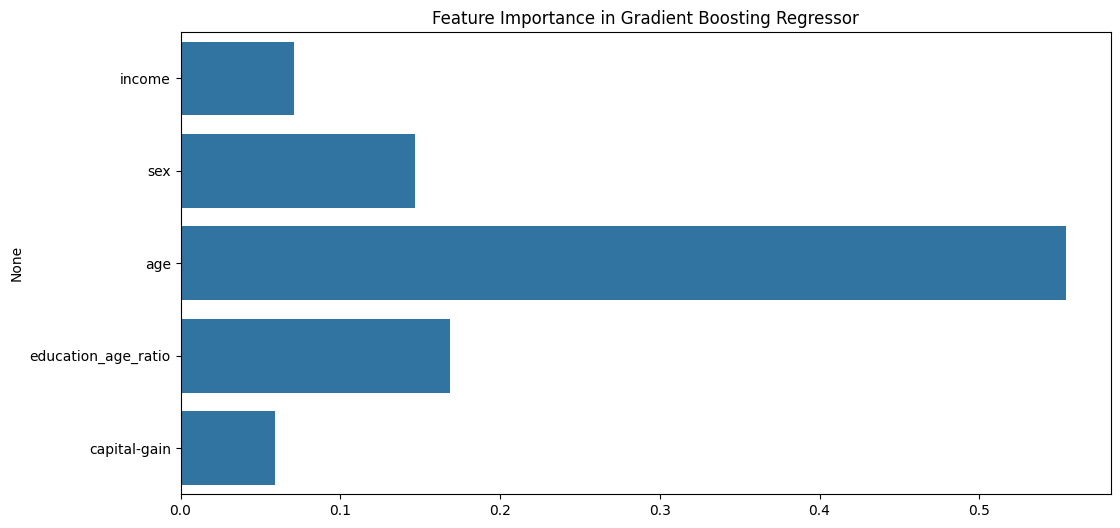

In [336]:
# Compare feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=best_dt_model.feature_importances_, y=X_train_normal.columns)
plt.title("Feature Importance in Decision Tree Regressor")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=rf_model.feature_importances_, y=X_train_normal.columns)
plt.title("Feature Importance in Random Forest Regressor")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=gb_model.feature_importances_, y=X_train_normal.columns)
plt.title("Feature Importance in Gradient Boosting Regressor")
plt.show()


In [337]:
models = ["SGDRegressor", "SGDRegressor with Polynomial Features","Tuned SGDRegressor with Polynomial Features",
        "DecisionTreeRegressor","DecisionTreeRegressor after Hyperparameter Tuning","Random Forest Regressor", 
        "Gradient Boosting Regressor","Tuned Decision Tree Regressor w/o some features", "Random Forest Regressor w/o some features",
        "Gradient Boosting Regressor w/o some features", "Decision Tree Regressor w/o some features"]

predictions = [y_pred_sgd, y_pred_sgdpoly, y_pred_sgdhyper, y_pred_dt, y_pred_best_tree,y_pred_rf, y_pred_gb, y_pred_best_dtnf, y_pred_rfnf,
               y_pred_gbnf, y_pred_dtnf]

In [339]:
results_dict = {
    "Model": models,
    "MAE": [mean_absolute_error(y_test, pred) for pred in predictions],
    "MSE": [mean_squared_error(y_test, pred) for pred in predictions],
    "RMSE": [np.sqrt(mean_squared_error(y_test, pred)) for pred in predictions],
    "RÂ² Score": [r2_score(y_test, pred) for pred in predictions]
}

results_df = pd.DataFrame(results_dict)
display(results_df)

Model       MAE         MSE  \
0                                        SGDRegressor  7.664096  118.032416   
1               SGDRegressor with Polynomial Features  7.518798  113.862560   
2         Tuned SGDRegressor with Polynomial Features  7.504634  113.462425   
3                               DecisionTreeRegressor  8.867152  161.234806   
4   DecisionTreeRegressor after Hyperparameter Tuning  7.422649  114.009724   
5                             Random Forest Regressor  7.427961  113.046559   
6                         Gradient Boosting Regressor  7.551499  116.373110   
7     Tuned Decision Tree Regressor w/o some features  7.519219  115.428238   
8           Random Forest Regressor w/o some features  7.526885  115.856787   
9       Gradient Boosting Regressor w/o some features  7.625045  118.757816   
10          Decision Tree Regressor w/o some features  8.127815  134.682619   

         RMSE  RÂ² Score  
0   10.864272  0.189911  
1   10.670640  0.218530  
2   10.651874  0.221276  
3   12.697827 -0.106599  
4   10.677534  0.217520  
5   10.632336  0.224130  
6   10.787637  0.201299  
7   10.743753  0.207784  
8   10.763679  0.204843  
9   10.897606  0.184932  
10  11.605284  0.075636

- **Best Linear Model: Tuned SGDRegressor with Polynomial Features**
  *  MAE: 7.50 (lowest among linear models)
  *  MSE: 113.46 (lowest among linear models)
  *  RMSE: 10.65 (lowest among linear models)
  *  RÂ² Score: 0.2213 (highest among linear models)
- Why?
  *  Adding polynomial features improved performance.
  *  Hyperparameter tuning helped minimize errors.
  *  Highest RÂ² score among linear models.

- **Best Decision Tree-Based Model: Random Forest Regressor**
  *  MAE: 7.42 (best among tree-based models)
  *  MSE: 113.04 (best among tree-based models)
  *  RMSE: 10.63 (best among tree-based models)
  *  RÂ² Score: 0.2241 (highest among tree-based models)
- Why?
  *  Random Forest mitigates overfitting issues seen in Decision Trees.
  *  It generalizes better compared to plain Decision Trees.
  *  Consistently lower errors compared to other tree-based models.

- **Best Overall Model: Random Forest Regressor**
  *  It has the best combination of low errors and high RÂ² score.
  *  It performs better than DecisionTreeRegressor and Gradient Boosting.
  *  It outperforms linear models, indicating that non-linearity is important in this dataset.

- General conclusions:
  *  Polynomial Features improved linear regression but still fell short compared to tree models.
  *  Tuned Decision Trees helped but still didnâ€™t outperform Random Forest.
  *  Random Forest performed the best, making it the recommended choice for deployment.